roe calculation


In [1]:
import pandas as pd
import os

# 🔁 STEP 1: Enter file paths
pnl_path = input("📁 Enter path to Net Profit Excel file (.xlsx): ").strip()
balance_path = input("📁 Enter path to Shareholders’ Equity Excel file (.xlsx): ").strip()

# ✅ Validate file existence
if not os.path.exists(pnl_path) or not os.path.exists(balance_path):
    raise FileNotFoundError("❌ One or both file paths are invalid. Check and try again.")

# 📥 STEP 2: Load first sheet from both files
pnl_df = pd.read_excel(pnl_path, sheet_name=0)
balance_df = pd.read_excel(balance_path, sheet_name=0)

# 🔍 STEP 3: Extract Net Profit rows
if "Metric" not in pnl_df.columns:
    raise ValueError("❌ 'Metric' column missing in P&L file.")

net_profit_df = pnl_df[pnl_df["Metric"].str.lower() == "net_profit"].copy()
net_profit_long = net_profit_df.melt(
    id_vars=["Company", "Metric"], var_name="Year", value_name="Net Profit"
)
net_profit_long.drop(columns="Metric", inplace=True)

# 🧮 STEP 4: Extract equity capital + reserves
required_metrics = ["equity capital", "reserves"]

if "Financial_Metric" not in balance_df.columns:
    raise ValueError("❌ 'Financial_Metric' column missing in Balance Sheet file.")

equity_df = balance_df[
    balance_df["Financial_Metric"].str.lower().isin(required_metrics)
].copy()
equity_df["Company"] = equity_df["Company"].str.replace("_Balance_Sheet", "", regex=False)

equity_long = equity_df.melt(
    id_vars=["Company", "Financial_Metric"], var_name="Year", value_name="Value"
)

equity_pivot = equity_long.pivot_table(
    index=["Company", "Year"], columns="Financial_Metric", values="Value"
).reset_index()

if not all(metric in equity_pivot.columns for metric in required_metrics):
    raise ValueError("❌ One or both required metrics ('equity capital', 'reserves') not found.")

equity_pivot["Shareholders' Equity"] = (
    equity_pivot["equity capital"] + equity_pivot["reserves"]
)

# 🔗 STEP 5: Merge with Net Profit
merged_df = pd.merge(
    net_profit_long,
    equity_pivot[["Company", "Year", "Shareholders' Equity"]],
    on=["Company", "Year"],
    how="inner"
)

# 🧠 STEP 6: Calculate ROE
merged_df["ROE"] = merged_df["Net Profit"] / merged_df["Shareholders' Equity"]

# 🔁 STEP 7: Reshape into final format
metrics = ['Net Profit', "Shareholders' Equity", 'ROE']
reshaped = []

for metric in metrics:
    temp_df = merged_df.pivot(index="Company", columns="Year", values=metric).reset_index()
    temp_df.insert(1, "Financial Metric", metric)
    reshaped.append(temp_df)

final_df = pd.concat(reshaped, ignore_index=True)
final_df.sort_values(by=["Company", "Financial Metric"], inplace=True)

# 💾 STEP 8: Save the final output
output_path = os.path.join(os.path.dirname(pnl_path), "ROE_Reordered_Formatted.xlsx")
final_df.to_excel(output_path, index=False)

print(f"\n✅ ROE (formatted) successfully calculated and saved to:\n{output_path}")



✅ ROE (formatted) successfully calculated and saved to:
C:\Users\LENOVO\Desktop\New folder\ROE\ROE_Reordered_Formatted.xlsx


 roce extraction per company (scrapping)

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import difflib
import re
import os

def scrape_table_section(ticker, section_id, target_metrics, year_from=None, year_to=None, consolidated=True):
    url = f"https://www.screener.in/company/{ticker}/"
    if consolidated:
        url += "consolidated/"

    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch {ticker}: HTTP {response.status_code}")

    soup = BeautifulSoup(response.content, "html.parser")
    section = soup.find("section", {"id": section_id})
    if not section:
        raise Exception(f"Section '{section_id}' not found on the page.")

    table = section.find("table")
    rows = table.find_all("tr")

    headers_row = rows[0].find_all(["th", "td"])
    all_years = [cell.get_text(strip=True) for cell in headers_row[1:]]

    def extract_year(text):
        match = re.search(r"\b(\d{4})\b", text)
        return int(match.group(1)) if match else None

    year_indices = []
    filtered_years = []

    for i, y in enumerate(all_years):
        y_num = extract_year(y)
        if y_num and (year_from is None or y_num >= year_from) and (year_to is None or y_num <= year_to):
            year_indices.append(i)
            filtered_years.append(y)

    data = {}

    for row in rows[1:]:
        cols = row.find_all(["th", "td"])
        row_name = cols[0].get_text(strip=True)
        values = [col.get_text(strip=True).replace("−", "-") for col in cols[1:]]

        match = difflib.get_close_matches(row_name.lower(), [m.lower() for m in target_metrics], n=1, cutoff=0.7)
        if match:
            proper_name = next((m for m in target_metrics if m.lower() == match[0]), row_name)
            filtered_values = [values[i] for i in year_indices if i < len(values)]
            data[proper_name] = filtered_values

    df = pd.DataFrame(data, index=filtered_years).T
    df.columns.name = "Year"
    df.index.name = "Metric"
    return df

# === MAIN SCRIPT ===
if __name__ == "__main__":
    print("\n🔍 Financial Metric Scraper from Screener.in")

    ticker = input("🏢 Enter company ticker (e.g., ULTRACEMCO): ").strip().upper()
    data_type = input("📊 Choose data type - Standalone or Consolidated: ").strip().lower()
    consolidated = data_type == "consolidated"

    print("\n📂 Select financial section to extract:")
    print("1 - Ratios")
    print("2 - Balance Sheet")
    print("3 - Profit & Loss")
    section_choice = input("Enter choice (1, 2, or 3): ").strip()

    section_map = {
        "1": "ratios",
        "2": "balance-sheet",
        "3": "profit-loss"
    }

    if section_choice not in section_map:
        print("❌ Invalid section choice.")
        exit()

    section_id = section_map[section_choice]

    ratios_input = input("📈 Enter financial metrics (comma-separated, e.g., ROCE, ROE): ")
    target_metrics = [x.strip() for x in ratios_input.split(",")]

    try:
        year_from = int(input("📅 Enter FROM year (e.g., 2019): ").strip())
        year_to = int(input("📅 Enter TO year (e.g., 2024): ").strip())
    except ValueError:
        print("❌ Invalid year input. Please enter valid numeric years.")
        exit()

    print("\n⏳ Scraping data, please wait...")
    try:
        df = scrape_table_section(ticker, section_id, target_metrics, year_from, year_to, consolidated)
    except Exception as e:
        print(f"❌ Error: {e}")
        exit()

    print("\n📊 Extracted Data:")
    print(df)

    # 💾 Save to Excel
    safe_metrics = "".join([m.replace(" ", "") for m in target_metrics])
    excel_file = f"{ticker}{section_id}{safe_metrics}{year_from}{year_to}.xlsx"
    df.to_excel(excel_file)
    print(f"\n✅ Data saved to: {os.path.abspath(excel_file)}")


🔍 Financial Metric Scraper from Screener.in

📂 Select financial section to extract:
1 - Ratios
2 - Balance Sheet
3 - Profit & Loss

⏳ Scraping data, please wait...

📊 Extracted Data:
Year   Dec 2013 Dec 2014 Dec 2015 Dec 2016 Dec 2017 Dec 2018 Dec 2019  \
Metric                                                                  
ROCE        17%      15%      12%      11%      16%      16%      19%   

Year   Dec 2020 Dec 2021 Mar 2023 Mar 2024 Mar 2025  
Metric                                               
ROCE        16%      19%       9%      17%      17%  

✅ Data saved to: d:\kiq\project\Riskify\Riskify-2\notebooks\Preprocessing\ACCratiosROCE20132025.xlsx


combined roce for 5 companies

In [4]:
import pandas as pd
from pathlib import Path
import re
import os

def clean_year_columns(df):
    """Extract year from column headers like 'Mar 2023'."""
    new_cols = []
    for col in df.columns:
        if isinstance(col, str):
            match = re.search(r'\b(20\d{2}|19\d{2})\b', col)
            new_cols.append(match.group(1) if match else col)
        else:
            new_cols.append(col)
    df.columns = new_cols
    return df

def convert_percentages_to_float(df):
    """Convert '12.5%' to 0.125 for numeric columns (except first)."""
    for col in df.columns[1:]:
        if df[col].dtype == object:
            df[col] = df[col].apply(lambda x: str(x).strip() if pd.notna(x) else x)
            df[col] = df[col].apply(
                lambda x: float(x.replace('%', '')) / 100 if isinstance(x, str) and '%' in x else x
            )
            df[col] = pd.to_numeric(df[col], errors='ignore')
    return df

# === User Input for Files ===
print("📂 Enter full file paths to Excel files (comma-separated):")
paths_input = input(">> ").strip()

file_paths = [p.strip() for p in paths_input.split(",") if p.strip()]
combined_data = []

for file_path in file_paths:
    try:
        df = pd.read_excel(file_path)
        df = clean_year_columns(df)
        df = convert_percentages_to_float(df)

        company_name = Path(file_path).stem.split("_")[0]
        df.insert(0, 'Company', company_name)

        combined_data.append(df)
        print(f"✅ Processed: {company_name}")

    except Exception as e:
        print(f"❌ Failed to read {file_path}: {e}")

# === Combine and Save ===
if combined_data:
    final_df = pd.concat(combined_data, ignore_index=True)

    print("\n💾 Enter output file path (or press Enter to use default):")
    output_path = input(">> ").strip()

    if not output_path:
        output_path = os.path.join(os.getcwd(), "Combined_Ratios_Converted_Percentages.xlsx")

    final_df.to_excel(output_path, index=False)
    print(f"\n✅ Saved combined file with % converted: {output_path}")
else:
    print("⚠ No data combined. Please check file paths.")

📂 Enter full file paths to Excel files (comma-separated):


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1792\952983229.py:26: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1792\952983229.py:26: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1792\952983229.py:26: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1792\952983229.py:26: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numer

✅ Processed: ULTRACEMCO
✅ Processed: ACC
✅ Processed: AMBUJACEM
✅ Processed: DALBHARAT
✅ Processed: SHREECEM

💾 Enter output file path (or press Enter to use default):

✅ Saved combined file with % converted: C:\Users\LENOVO\Desktop\New folder\roce.xlsx


ROE, ROCE, Net Profit Margin – Compare across years.
Rank companies by average ROE and ROCE.

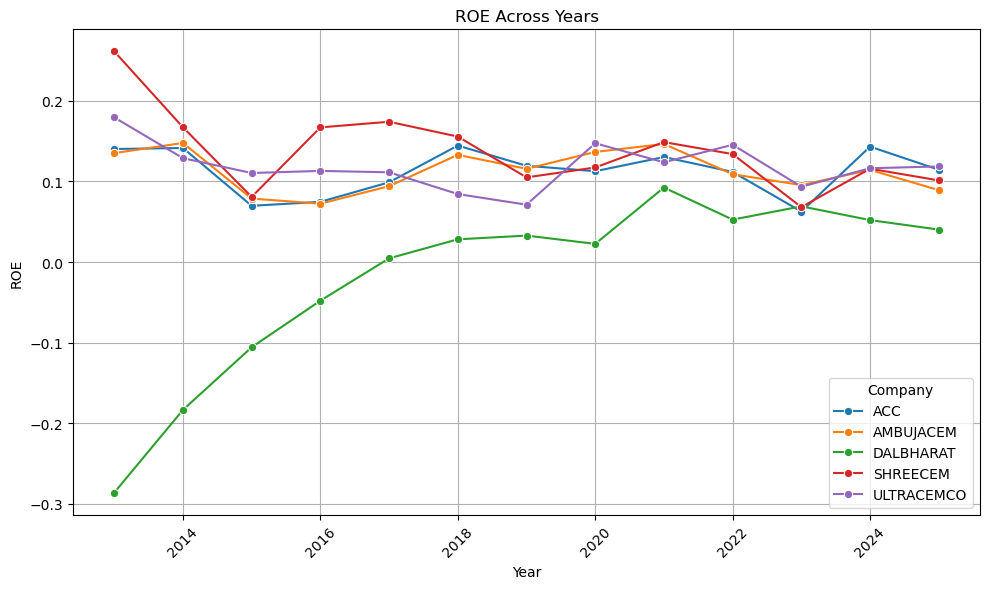

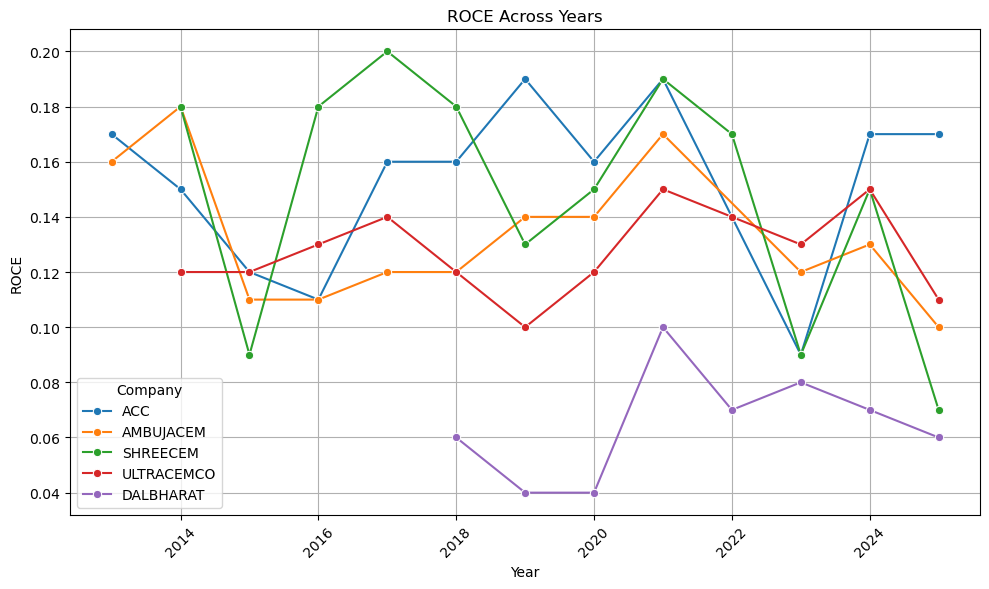

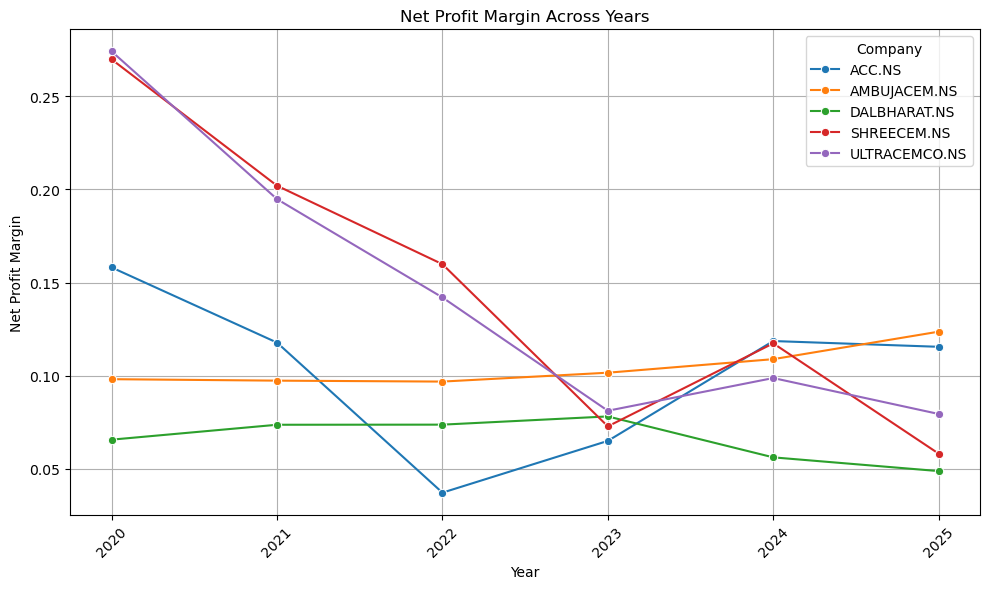

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6852\419822906.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_roe.values, y=avg_roe.index, palette='Blues_d')


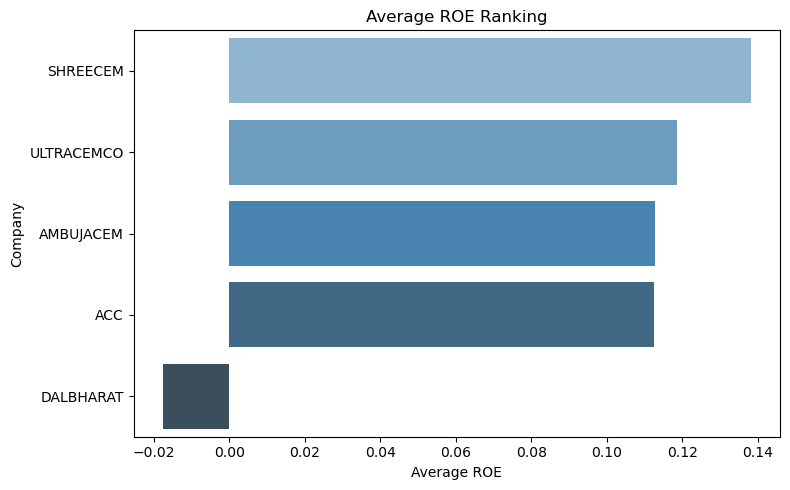

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6852\419822906.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_roce.values, y=avg_roce.index, palette='Greens_d')


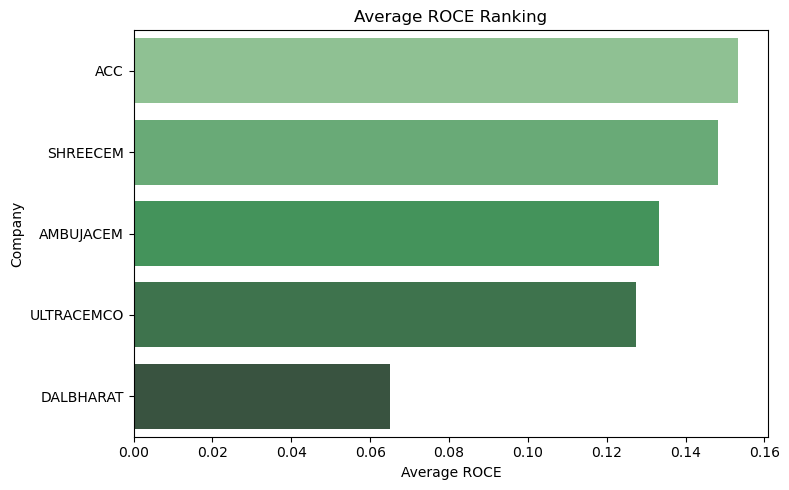

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === User input for file path ===
file_path = input("📁 Enter the path to your Excel file: ").strip()

# === Check if the file exists ===
if not os.path.exists(file_path):
    print("❌ The file path you entered does not exist.")
else:
    # === Load the merged Excel file ===
    df = pd.read_excel(file_path)

    # === Melt the dataframe to long format ===
    year_columns = [col for col in df.columns if str(col).isdigit()]
    df_long = df.melt(id_vars=['Company', 'Metric'], value_vars=year_columns,
                      var_name='Year', value_name='Value')
    df_long.dropna(subset=['Value'], inplace=True)

    # === Filter each metric ===
    roe_df = df_long[df_long['Metric'] == 'roe'].copy()
    roce_df = df_long[df_long['Metric'] == 'roce'].copy()
    npm_df = df_long[df_long['Metric'] == 'net_profit_margin'].copy()

    # === Compute average ROE and ROCE for ranking ===
    avg_roe = roe_df.groupby('Company')['Value'].mean().sort_values(ascending=False)
    avg_roce = roce_df.groupby('Company')['Value'].mean().sort_values(ascending=False)

    # === Plot ROE across years ===
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=roe_df, x='Year', y='Value', hue='Company', marker='o')
    plt.title("ROE Across Years")
    plt.ylabel("ROE")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Plot ROCE across years ===
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=roce_df, x='Year', y='Value', hue='Company', marker='o')
    plt.title("ROCE Across Years")
    plt.ylabel("ROCE")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Plot Net Profit Margin across years ===
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=npm_df, x='Year', y='Value', hue='Company', marker='o')
    plt.title("Net Profit Margin Across Years")
    plt.ylabel("Net Profit Margin")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Bar chart for Average ROE ===
    plt.figure(figsize=(8, 5))
    sns.barplot(x=avg_roe.values, y=avg_roe.index, palette='Blues_d')
    plt.title("Average ROE Ranking")
    plt.xlabel("Average ROE")
    plt.tight_layout()
    plt.show()

    # === Bar chart for Average ROCE ===
    plt.figure(figsize=(8, 5))
    sns.barplot(x=avg_roce.values, y=avg_roce.index, palette='Greens_d')
    plt.title("Average ROCE Ranking")
    plt.xlabel("Average ROCE")
    plt.tight_layout()
    plt.show()

current and quick  (liquidity ratio)

In [4]:
import pandas as pd
import os

# 📁 Step 1: Input File
input_path = input("📁 Enter path to input Excel file (.xlsx): ").strip()

if not os.path.exists(input_path):
    raise FileNotFoundError("❌ File not found. Check the path and try again.")

# 📥 Step 2: Load Data
df = pd.read_excel(input_path)
df["Financial Metric"] = df["Financial Metric"].str.lower()

# 📌 Step 3: Define Metric Groups
required_metrics = {
    "current_liabilities": [
        "short term borrowings",
        "lease liabilities",
        "trade payables",
        "advance from customers",
        "other liability items"
    ],
    "current_assets": [
        "inventories",
        "cash equivalents",
        "trade receivables"
    ],
    "quick_assets": [
        "cash equivalents",
        "trade receivables"
    ]
}

# 🧮 Step 4: Function to calculate metric sum
def calculate_metric_sum(df, metric_list, new_metric_name):
    sub_df = df[df["Financial Metric"].isin(metric_list)].copy()
    sub_df.set_index(["Company", "Financial Metric"], inplace=True)
    grouped = sub_df.groupby(level=0).sum()
    grouped["Financial Metric"] = new_metric_name
    result = grouped.reset_index()
    cols = ["Company", "Financial Metric"] + [col for col in result.columns if col not in ["Company", "Financial Metric"]]
    return result[cols]

# 🔢 Step 5: Calculate Current Liabilities & Current Assets
current_liabilities = calculate_metric_sum(df, required_metrics["current_liabilities"], "current liabilities")
current_assets = calculate_metric_sum(df, required_metrics["current_assets"], "current assets")
quick_assets = calculate_metric_sum(df, required_metrics["quick_assets"], "quick assets")  # ✅ new quick assets

# 🔗 Step 6: Melt for ratio calculation
def melt_for_merge(df, metric_name):
    return df.melt(id_vars=["Company", "Financial Metric"], var_name="Year", value_name=metric_name)

cl_long = melt_for_merge(current_liabilities, "Current Liabilities")
ca_long = melt_for_merge(current_assets, "Current Assets")
qa_long = melt_for_merge(quick_assets, "Quick Assets")

# 🔢 Step 7: Current Ratio = Current Assets / Current Liabilities
current_ratio = pd.merge(ca_long, cl_long, on=["Company", "Year"])
current_ratio["Value"] = current_ratio["Current Assets"] / current_ratio["Current Liabilities"]
current_ratio["Financial Metric"] = "current ratio"

# 🔢 Step 8: Quick Ratio = Quick Assets / Current Liabilities
quick_ratio = pd.merge(qa_long, cl_long, on=["Company", "Year"])
quick_ratio["Value"] = quick_ratio["Quick Assets"] / quick_ratio["Current Liabilities"]
quick_ratio["Financial Metric"] = "quick ratio"

# 🔄 Step 9: Pivot back to wide format
current_ratio_pivot = current_ratio.pivot(index="Company", columns="Year", values="Value").reset_index()
current_ratio_pivot.insert(1, "Financial Metric", "current ratio")
current_ratio_pivot = current_ratio_pivot.round(2)  # Rounded

quick_ratio_pivot = quick_ratio.pivot(index="Company", columns="Year", values="Value").reset_index()
quick_ratio_pivot.insert(1, "Financial Metric", "quick ratio")  # No rounding for full decimals

# 📊 Step 10: Combine all
final_df = pd.concat([
    df,
    current_liabilities,
    current_assets,
    quick_assets,
    current_ratio_pivot,
    quick_ratio_pivot
], ignore_index=True)

final_df.sort_values(by=["Company", "Financial Metric"], inplace=True)

# 💾 Step 11: Save result
output_path = os.path.join(os.path.dirname(input_path), "Current_Quick_Ratios_Final.xlsx")
final_df.to_excel(output_path, index=False)

print(f"\n✅ Final metrics (incl. quick assets) calculated and saved to:\n{output_path}")


✅ Final metrics (incl. quick assets) calculated and saved to:
C:\Users\LENOVO\Desktop\New folder\AVG INVENTO\ALL IN ONE\Current_Quick_Ratios_Final.xlsx


avg inventory


In [6]:
import pandas as pd
import os

# 📥 Step 1: Load input Excel file
input_path = input("📁 Enter path to your Excel file (.xlsx): ").strip()

if not os.path.exists(input_path):
    raise FileNotFoundError("❌ File not found. Check the path and try again.")

df = pd.read_excel(input_path)
df["Financial Metric"] = df["Financial Metric"].str.lower()

# 📌 Step 2: Filter only 'inventories'
inventory_df = df[df["Financial Metric"] == "inventories"].copy()

# 🧮 Step 3: Calculate average inventory for FY(N)
avg_inventory_rows = []

year_columns = [col for col in df.columns if col not in ["Company", "Financial Metric"]]
year_columns_sorted = sorted(year_columns)  # Ensure years are sorted numerically as strings

for _, row in inventory_df.iterrows():
    company = row["Company"]
    prev_value = None

    avg_row = {"Company": company, "Financial Metric": "average inventory"}

    for year in year_columns_sorted:
        current_value = row[year]

        if prev_value is not None and pd.notna(prev_value) and pd.notna(current_value):
            avg_row[year] = (prev_value + current_value) / 2
        else:
            avg_row[year] = None

        prev_value = current_value

    avg_inventory_rows.append(avg_row)

# 📊 Step 4: Create DataFrame from calculated rows
avg_inventory_df = pd.DataFrame(avg_inventory_rows)

# 🧾 Step 5: Append to original DataFrame
combined_df = pd.concat([df, avg_inventory_df], ignore_index=True)
combined_df.sort_values(by=["Company", "Financial Metric"], inplace=True)

# 💾 Step 6: Save output
output_path = os.path.join(os.path.dirname(input_path), "Average_Inventory_Output.xlsx")
combined_df.to_excel(output_path, index=False)

print(f"\n✅ Average Inventory successfully calculated and saved to:\n{output_path}")

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6852\529570802.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([df, avg_inventory_df], ignore_index=True)



✅ Average Inventory successfully calculated and saved to:
C:\Users\LENOVO\Desktop\New folder\AVG INVENTO\Average_Inventory_Output.xlsx


cogs and inventory turnover

In [8]:
import pandas as pd
import numpy as np

# 1) ASK USER FOR FILE PATHS
pnl_path = input("📁 Enter full path to Combined_Annual_P&L_Pivot_interpolated.xlsx: ").strip('"')
inv_path = input("📁 Enter full path to Average_Inventory_Output.xlsx: ").strip('"')

# 2) LOAD EXCEL FILES
pnl_df = pd.read_excel(pnl_path)
inventory_df = pd.read_excel(inv_path)

# 3) STANDARDIZE COMPANY NAMES
company_name_map = {
    "AMBUJACEM":   "AmbujaCement",
    "DALBHARAT":   "DalmiaBharat",
    "SHREECEM":    "ShreeCement",
    "ULTRACEMCO":  "UltraTech"
}
pnl_df["Company"] = pnl_df["Company"].replace(company_name_map)
inventory_df["Company"] = inventory_df["Company"].replace(company_name_map)

# 4) FILTER METRICS FROM P&L
sales_df = pnl_df[pnl_df["Metric"].str.lower() == "sales"]
op_profit_df = pnl_df[pnl_df["Metric"].str.lower() == "operating_profit"]

# 5) MELT P&L TO LONG FORMAT
sales_long = sales_df.melt(id_vars=["Company", "Metric"], var_name="Year", value_name="Sales")
op_profit_long = op_profit_df.melt(id_vars=["Company", "Metric"], var_name="Year", value_name="Operating_Profit")

# 6) MERGE SALES + OPERATING PROFIT → CALCULATE COGS
merged_df = pd.merge(
    sales_long[["Company", "Year", "Sales"]],
    op_profit_long[["Company", "Year", "Operating_Profit"]],
    on=["Company", "Year"],
    how="inner"
)
merged_df["COGS"] = merged_df["Sales"] - merged_df["Operating_Profit"]

# 7) HANDLE INVENTORY DATA
# Filter if extra column present
if "Financial Metric" in inventory_df.columns:
    inventory_df = inventory_df[inventory_df["Financial Metric"].str.lower() == "average inventory"]

inventory_long = inventory_df.melt(
    id_vars=["Company"],
    var_name="Year",
    value_name="Average_Inventory"
)

inventory_long["Average_Inventory"] = pd.to_numeric(inventory_long["Average_Inventory"], errors="coerce")
inventory_long["Average_Inventory"] = inventory_long["Average_Inventory"].replace(0, np.nan)

# 8) FINAL MERGE → ADD INVENTORY
final_df = pd.merge(merged_df, inventory_long, on=["Company", "Year"], how="inner")

# 9) CALCULATE INVENTORY TURNOVER
final_df["Inventory_Turnover"] = final_df["COGS"] / final_df["Average_Inventory"]

# 10) PREPARE FINAL LONG FORMAT
def make_metric_df(df, column, metric_name):
    out = df[["Company", "Year", column]].copy()
    out["Metric"] = metric_name
    out = out.rename(columns={column: "Value"})
    return out

all_metrics = pd.concat([
    make_metric_df(final_df, "Sales", "Sales"),
    make_metric_df(final_df, "Operating_Profit", "Operating Profit"),
    make_metric_df(final_df, "COGS", "COGS"),
    make_metric_df(final_df, "Average_Inventory", "Average Inventory"),
    make_metric_df(final_df, "Inventory_Turnover", "Inventory Turnover"),
], ignore_index=True)

# 11) PIVOT TO WIDE FORMAT
pivot_df = all_metrics.pivot_table(
    index=["Company", "Metric"],
    columns="Year",
    values="Value",
    aggfunc="mean"
).reset_index()

# Round values and replace NaNs with blank for Excel
pivot_df = pivot_df.round(2)
pivot_df = pivot_df.fillna("")

# 12) EXPORT TO EXCEL
output_file = "Full_COGS_Inventory_Analysis.xlsx"
pivot_df.to_excel(output_file, index=False)

print(f"✅ Output saved to: {output_file}")

✅ Output saved to: Full_COGS_Inventory_Analysis.xlsx


debt to equity 

In [9]:
import pandas as pd

# Ask user for input file path
file_path = input("Enter the full path of your Excel file: ")

try:
    # Load the Excel file
    df = pd.read_excel(file_path)

    # Clean up column values
    df["Financial_Metric"] = df["Financial_Metric"].str.strip().str.lower()
    df["Company"] = df["Company"].str.strip()

    # Dynamically detect year columns
    year_cols = [col for col in df.columns if str(col).isdigit()]

    # Identify borrowings and shareholders' equity rows using keyword matching
    borrowings_mask = df["Financial_Metric"].str.contains("borrowing", case=False)
    equity_mask = df["Financial_Metric"].str.contains("shareholder.*equity", case=False)

    # Extract matching rows
    borrowings_df = df[borrowings_mask].set_index("Company")
    equity_df = df[equity_mask].set_index("Company")

    # Find common companies
    common_companies = borrowings_df.index.intersection(equity_df.index)

    # Select year columns only
    borrowings_df = borrowings_df.loc[common_companies, year_cols]
    equity_df = equity_df.loc[common_companies, year_cols]

    # Avoid division by zero
    equity_df.replace(0, pd.NA, inplace=True)

    # Calculate Debt-to-Equity Ratio
    de_ratio = borrowings_df / equity_df

    # Insert identifier columns
    de_ratio.insert(0, "Financial_Metric", "Debt-to-Equity")
    de_ratio.insert(0, "Company", common_companies)

    # Reset index for output formatting
    de_ratio.reset_index(drop=True, inplace=True)

    # Save output
    output_file = "debt_to_equity_dynamic_output.xlsx"
    de_ratio.to_excel(output_file, index=False)
    print(f"\n✅ Debt-to-Equity ratios saved to: {output_file}")
    print(de_ratio)

except FileNotFoundError:
    print("❌ File not found. Please check the path and try again.")

except Exception as e:
    print(f"❌ An error occurred: {e}")


✅ Debt-to-Equity ratios saved to: debt_to_equity_dynamic_output.xlsx
                    Company Financial_Metric      2013      2014      2015  \
0         ACC_Balance_Sheet   Debt-to-Equity  0.004480  0.000000  0.000000   
1   AMBUJACEM_Balance_Sheet   Debt-to-Equity  0.005073  0.003376  0.003408   
2   DALBHARAT_Balance_Sheet   Debt-to-Equity  2.977995  2.248912  1.685754   
3    SHREECEM_Balance_Sheet   Debt-to-Equity  0.335068  0.254723  0.173806   
4  ULTRACEMCO_Balance_Sheet   Debt-to-Equity  0.211048  0.426726  0.516202   

       2016      2017      2018      2019      2020      2021      2022  \
0  0.000000  0.000000  0.000000  0.000000  0.008032  0.008806  0.011934   
1  0.001463  0.001161  0.001788  0.001703  0.020697  0.018814  0.013638   
2  1.255376  0.834770  0.703048  0.552966  0.572768  0.299688  0.197746   
3  0.128688  0.167966  0.382488  0.289836  0.238894  0.144833  0.121936   
4  0.483755  0.347409  0.738382  0.750704  0.589566  0.491658  0.224026   

       202

interest coverge ratio

In [14]:
import pandas as pd

# Prompt user for Excel file path
file_path = input("Enter the path to your Excel file (e.g., balance_sheet.xlsx): ").strip()

# Remove surrounding quotes if present
if file_path.startswith('"') and file_path.endswith('"'):
    file_path = file_path[1:-1]
if file_path.startswith("'") and file_path.endswith("'"):
    file_path = file_path[1:-1]

# Load Excel file
try:
    df = pd.read_excel(file_path)
except FileNotFoundError:
    print(f"❌ File not found: {file_path}")
    exit()
except Exception as e:
    print(f"❌ Error loading file: {e}")
    exit()

# Convert column names to lowercase
df.columns = [str(col).lower() for col in df.columns]

# Check for required columns
required_cols = {'company', 'metric'}
if not required_cols.issubset(set(df.columns)):
    print(f"❌ Required columns {required_cols} not found in the file.")
    print("Available columns:")
    print(df.columns)
    exit()

# Identify year columns (numeric names)
year_cols = [col for col in df.columns if col.isdigit()]

# Prepare list to collect new rows
coverage_rows = []

# Process each company
for company in df['company'].unique():
    company_data = df[df['company'] == company]

    op_profit_row = company_data[company_data['metric'].str.lower() == 'operating_profit']
    interest_row = company_data[company_data['metric'].str.lower() == 'interest']

    if op_profit_row.empty or interest_row.empty:
        print(f"⚠️ Skipping company '{company}' — missing operating_profit or interest row.")
        continue

    coverage = {'company': company, 'metric': 'Interest Coverage Ratio'}
    for year in year_cols:
        op_profit = op_profit_row[year].values[0]
        interest = interest_row[year].values[0]
        if interest != 0:
            coverage[year] = op_profit / interest
        else:
            coverage[year] = None  # or np.nan if you prefer

    coverage_rows.append(coverage)

# Create DataFrame from new rows
coverage_df = pd.DataFrame(coverage_rows)

# Append to original DataFrame
final_df = pd.concat([df, coverage_df], ignore_index=True)

# Create output file name
output_file = file_path.replace('.xlsx', '_with_coverage.xlsx')

# Save to new Excel file
final_df.to_excel(output_file, index=False)

print(f"✅ Interest Coverage Ratio calculated per company and saved to: {output_file}")


✅ Interest Coverage Ratio calculated per company and saved to: C:\Users\LENOVO\Desktop\New folder\ROE\Combined_Annual_P&L_Pivot_interpolated_with_revenue_with_coverage.xlsx


combined ratio company wise

In [10]:
import pandas as pd
import os

# Step 1: Ask user to input 6 file paths
file_paths = []
print("📁 Enter paths for 6 Excel files (one by one):")
for i in range(6):
    path = input(f"Path {i+1}: ").strip().strip('"').strip("'")
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    file_paths.append(path)

# Step 2: Ask how many metrics to extract
try:
    count = int(input("🔢 How many metrics do you want to extract? "))
except ValueError:
    raise ValueError("Please enter a valid number.")

# Step 3: Get metrics one by one
desired_metrics = []
for i in range(count):
    metric = input(f"📝 Enter metric {i+1}: ").strip()
    desired_metrics.append(metric)

# Step 4: Prepare known variants
metric_column_variants = {'metric', 'Metric', 'Financial_Metric', 'Financial Metric'}
company_column_variants = {'company', 'Company'}

# Step 5: Define the valid year columns
valid_years = list(map(str, range(2012, 2026)))

# Step 6: Process each file
combined_data = []

for file_path in file_paths:
    df = pd.read_excel(file_path)
    df.columns = df.columns.map(str)  # Normalize all column names to strings
    df = df.loc[:, ~df.columns.duplicated()]  # Remove duplicate columns

    # Detect Metric column
    found_metric_col = next((col for col in df.columns if col.strip() in metric_column_variants), None)
    if not found_metric_col:
        raise ValueError(f"No recognizable 'Metric' column found in: {file_path}")
    df.rename(columns={found_metric_col: 'Metric'}, inplace=True)

    # Detect Company column
    found_company_col = next((col for col in df.columns if col.strip() in company_column_variants), None)
    if not found_company_col:
        raise ValueError(f"No recognizable 'Company' column found in: {file_path}")
    df.rename(columns={found_company_col: 'Company'}, inplace=True)

    # Filter rows
    df_filtered = df[df['Metric'].isin(desired_metrics)].copy()

    # Add missing year columns
    for y in valid_years:
        if y not in df_filtered.columns:
            df_filtered[y] = None

    # Keep only required columns
    df_filtered = df_filtered[['Company', 'Metric'] + valid_years]

    # Drop duplicate (Company, Metric)
    df_filtered = df_filtered.drop_duplicates(subset=['Company', 'Metric'])

    combined_data.append(df_filtered)

# Combine all files together
final_df = pd.concat(combined_data, ignore_index=True)

# Drop duplicate metric entries again just in case
final_df = final_df.drop_duplicates(subset=['Company', 'Metric'])

# Sort by Company then Metric
final_df = final_df.sort_values(by=['Company', 'Metric']).reset_index(drop=True)

# Save output
output_path = "CompanyWise_Metrics_WideFormat_Final.xlsx"
final_df.to_excel(output_path, index=False)

print(f"\n✅ Final cleaned and de-duplicated data saved to: {output_path}")

📁 Enter paths for 6 Excel files (one by one):


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6852\3710099867.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat(combined_data, ignore_index=True)



✅ Final cleaned and de-duplicated data saved to: CompanyWise_Metrics_WideFormat_Final.xlsx


radar chart

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6852\790232877.py:111: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\LENOVO\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


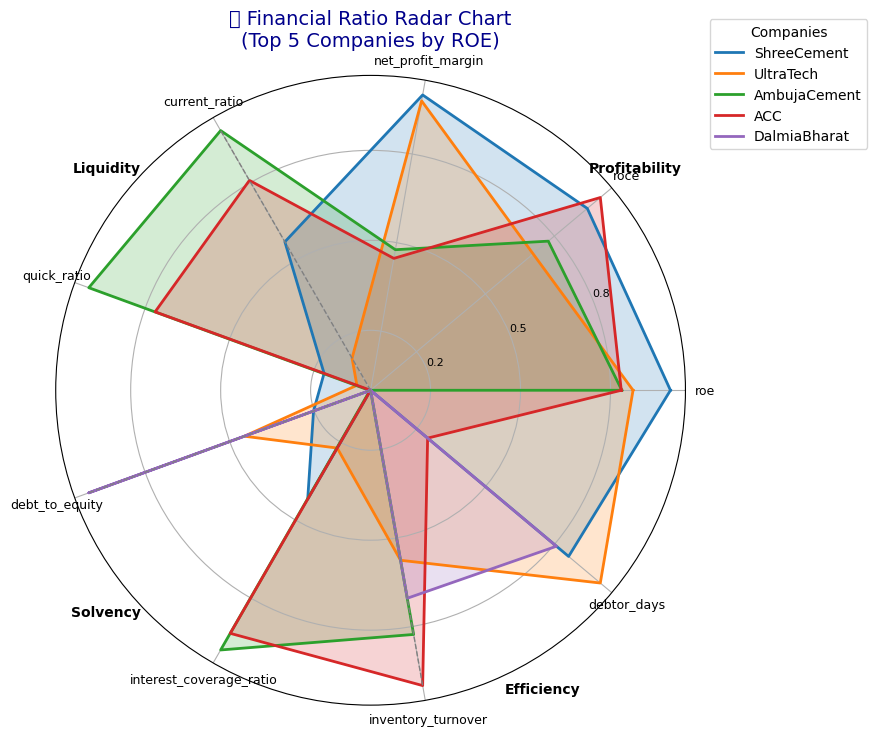

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 📁 Step 1: Load data
file_path = input("📁 Enter path to the Excel file: ").strip('"').strip("'")
df = pd.read_excel(file_path)

# 🔣 Normalize column names
df.columns = df.columns.str.strip().str.lower()
df['metric'] = df['metric'].str.strip().str.lower()
df['company'] = df['company'].str.strip()

# 🎯 Standardize metric names
metric_map = {
    'roe': 'roe',
    'roce': 'roce',
    'net profit margin': 'net_profit_margin',
    'interest coverage ratio': 'interest_coverage_ratio',
    'current ratio': 'current_ratio',
    'quick ratio': 'quick_ratio',
    'debt-to-equity': 'debt_to_equity',
    'debtor days': 'debtor_days',
    'inventory turnover': 'inventory_turnover'
}
df['metric'] = df['metric'].replace(metric_map)

# 🏷 Standardize company names
company_map = {
    'ACC': 'ACC', 'ACC.NS': 'ACC', 'ACC_Balance_Sheet': 'ACC',
    'AMBUJACEM': 'AmbujaCement', 'AMBUJACEM.NS': 'AmbujaCement', 'AMBUJACEM_Balance_Sheet': 'AmbujaCement',
    'AmbujaCement': 'AmbujaCement',
    'DALBHARAT': 'DalmiaBharat', 'DALBHARAT.NS': 'DalmiaBharat', 'DALBHARAT_Balance_Sheet': 'DalmiaBharat',
    'DalmiaBharat': 'DalmiaBharat',
    'SHREECEM': 'ShreeCement', 'SHREECEM.NS': 'ShreeCement', 'SHREECEM_Balance_Sheet': 'ShreeCement',
    'ShreeCement': 'ShreeCement',
    'ULTRACEMCO': 'UltraTech', 'ULTRACEMCO.NS': 'UltraTech', 'ULTRACEMCO_Balance_Sheet': 'UltraTech',
    'UltraTech': 'UltraTech'
}
df['company'] = df['company'].replace(company_map)

# 📅 Reshape years to long format
year_cols = [col for col in df.columns if col.isnumeric()]
df_long = df.melt(id_vars=['company', 'metric'], value_vars=year_cols,
                  var_name='year', value_name='value').dropna()

# 🔍 Filter required metrics
required_metrics = list(metric_map.values())
df_filtered = df_long[df_long['metric'].isin(required_metrics)]

# 🧮 Average values
df_avg = df_filtered.groupby(['company', 'metric'])['value'].mean().reset_index()

# 📊 Pivot for radar chart
df_pivot = df_avg.pivot(index='company', columns='metric', values='value')
df_pivot = df_pivot.dropna(subset=required_metrics)

# 🏆 Top 5 companies by ROE
top_companies = df_pivot.sort_values(by='roe', ascending=False).head(5)

# 🎯 Radar Chart Setup
metrics = required_metrics
categories = {
    "Profitability": ['roe', 'roce', 'net_profit_margin'],
    "Liquidity": ['current_ratio', 'quick_ratio'],
    "Solvency": ['debt_to_equity', 'interest_coverage_ratio'],
    "Efficiency": ['inventory_turnover', 'debtor_days']
}

# Reorder by categories
ordered_metrics = [m for cat in categories.values() for m in cat]
angles = np.linspace(0, 2 * np.pi, len(ordered_metrics), endpoint=False).tolist()
angles += angles[:1]  # Close the loop

# Normalize values
scaler = MinMaxScaler()
normalized = scaler.fit_transform(top_companies[ordered_metrics])
normalized = np.concatenate([normalized, normalized[:, [0]]], axis=1)

# 🎨 Plot Radar Chart
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))
colors = plt.cm.tab10.colors

for idx, (company, values) in enumerate(zip(top_companies.index, normalized)):
    ax.plot(angles, values, label=company, color=colors[idx], linewidth=2)
    ax.fill(angles, values, alpha=0.2, color=colors[idx])

# 🧭 Labeling
ax.set_xticks(angles[:-1])
ax.set_xticklabels(ordered_metrics, fontsize=9)
ax.set_yticks([0.2, 0.5, 0.8])
ax.set_yticklabels(["0.2", "0.5", "0.8"], fontsize=8)
ax.set_title("📊 Financial Ratio Radar Chart\n(Top 5 Companies by ROE)", fontsize=14, color='darkblue')

# 📚 Add category labels (optional decoration lines)
category_boundaries = [0]
for cat in categories.values():
    category_boundaries.append(category_boundaries[-1] + len(cat))

for i in category_boundaries[1:-1]:
    ax.plot([angles[i], angles[i]], [0, 1], '--', color='grey', lw=1)

# 🏷 Category annotations
category_labels = list(categories.keys())
for i, cat in enumerate(category_labels):
    middle_angle = np.mean([angles[category_boundaries[i]], angles[category_boundaries[i+1]-1]])
    ax.text(middle_angle, 1.15, cat, ha='center', va='center', fontsize=10, color='black', weight='bold')

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), title="Companies")
plt.tight_layout()
plt.show()


heat map

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6852\2957736639.py:52: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\LENOVO\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


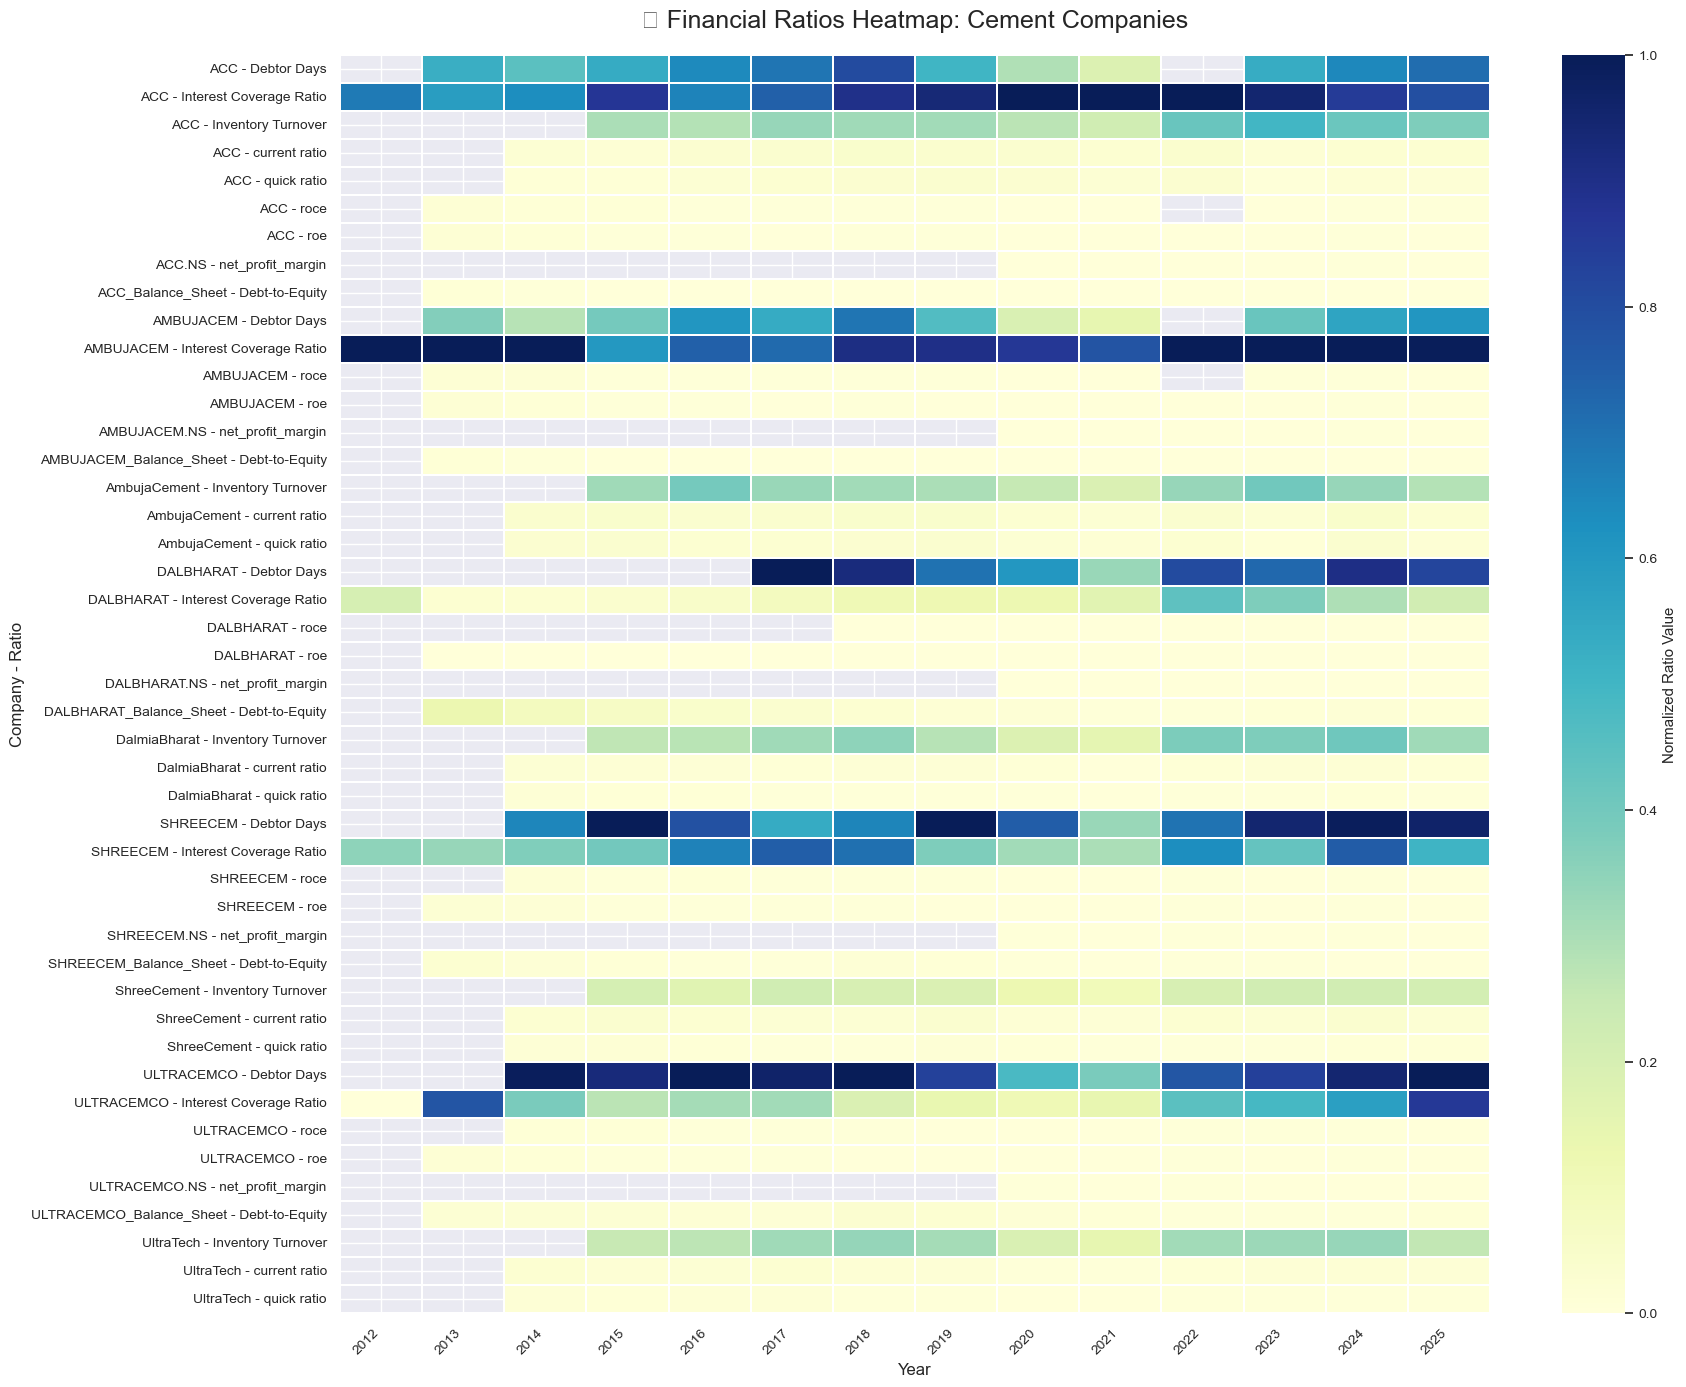

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os

# === Step 1: Get file path from user ===
file_path = input("📁 Enter full Excel file path (e.g., C:\\Users\\...\\file.xlsx): ").strip()

# === Step 2: Check if file exists ===
if not os.path.isfile(file_path):
    print("❌ File not found. Please check the path and try again.")
else:
    try:
        # === Step 3: Load data ===
        df = pd.read_excel(file_path)

        # Combine Company and Metric
        df['Label'] = df['Company'] + ' - ' + df['Metric']

        # Identify year columns
        year_columns = [col for col in df.columns if str(col).isdigit()]
        heatmap_data = df.set_index('Label')[year_columns]

        # Normalize data row-wise
        heatmap_data_scaled = pd.DataFrame(
            MinMaxScaler().fit_transform(heatmap_data),
            index=heatmap_data.index,
            columns=heatmap_data.columns
        )

        # === Step 4: Plot heatmap ===
        plt.figure(figsize=(18, 14))
        sns.set(font_scale=0.9)
        ax = sns.heatmap(
            heatmap_data_scaled,
            cmap='YlGnBu',
            linewidths=0.3,
            linecolor='white',
            cbar_kws={'label': 'Normalized Ratio Value'},
            square=False,
            xticklabels=True,
            yticklabels=True
        )

        # Titles and labels
        plt.title("📊 Financial Ratios Heatmap: Cement Companies", fontsize=18, pad=20)
        plt.xlabel("Year", fontsize=12)
        plt.ylabel("Company - Ratio", fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print("⚠ Error reading or processing the file:", e)